In [1]:
import pandas as pd
from ml.data import basic_preprocess

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
df, cat_cols, num_cols, target =  basic_preprocess(train, train=True, target='Transported')
df_test, _, _ , _ = basic_preprocess(test, train=False, target='Transported')

2022-11-02 07:40:50 INFO Replacing " " and "-" with "_" in and  column names and converting to lower case
2022-11-02 07:40:50 INFO Converting CryoSleep to binary
2022-11-02 07:40:50 INFO Converting VIP to binary
2022-11-02 07:40:50 INFO Splitting "cabin" from `deck/num/side` to `deck` `number` and `side`
2022-11-02 07:40:50 INFO Found 6 categorical columns
2022-11-02 07:40:50 INFO Categorical columns: ['passengerid', 'homeplanet', 'destination', 'name', 'cabin_deck', 'cabin_side']
2022-11-02 07:40:50 INFO Found 10 numerical columns
2022-11-02 07:40:50 INFO Numerical columns: ['cryosleep', 'age', 'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'transported', 'cabin_number']
2022-11-02 07:40:50 INFO Converting str to lower case
2022-11-02 07:40:50 INFO Converting target to binary
2022-11-02 07:40:50 INFO Removing target from cat_cols or num_cols
2022-11-02 07:40:50 INFO Filling categorical columns with mode
2022-11-02 07:40:50 INFO Filling numerical columns with mean


In [4]:
df.head()

,passengerid,homeplanet,cryosleep,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,cabin_deck,cabin_number,cabin_side
0,0001_01,europa,0.0,trappist-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,maham ofracculy,0,b,0.0,p
1,0002_01,earth,0.0,trappist-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,juanna vines,1,f,0.0,s
2,0003_01,europa,0.0,trappist-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,altark susent,0,a,0.0,s
3,0003_02,europa,0.0,trappist-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,solam susent,0,a,0.0,s
4,0004_01,earth,0.0,trappist-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,willy santantines,1,f,1.0,s


In [5]:
cat_cols

['homeplanet', 'destination', 'cabin_deck', 'cabin_side']

## Convert to dict_vectorizer

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# Final features
cat_cols_to_use = ['homeplanet', 'cabin_deck', 'cabin_side', 'destination']
final_cols = cat_cols_to_use + list(num_cols)

# Split data into train and validation
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

# Split data into X and y
X_train_df = df_train.drop(target, axis=1)
y_train = df_train[target]

X_val_df = df_val.drop(target, axis=1)
y_val = df_val[target]

# convert to dicts
train_dicts = X_train_df[final_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)

# transform dicts
X_train = dv.transform(train_dicts)
val_dicts = X_val_df[final_cols].to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Train Randon Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)

# Predict on validation data
y_pred_prob = model.predict_proba(X_val)[:, 1]
y_pred = y_pred_prob > 0.5

from ml.model import print_metrics
print_metrics(y_val, y_pred, y_pred_prob)


Accuracy: 0.802
Precision: 0.834
Recall: 0.769
F1: 0.800
AUC: 0.882


## Train XGBoost

In [8]:
import xgboost as xgb

# convert data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

# Train model
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'val')], early_stopping_rounds=10, verbose_eval=100)

# Predict on validation data
y_pred_prob = model.predict(dval)
y_pred = y_pred_prob > 0.5

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
accuracy = accuracy_score(y_val, y_pred)

print(f'****** Accuracy: {accuracy}')
print('******************************')

[0]	val-auc:0.79059
[99]	val-auc:0.90442
****** Accuracy: 0.8142610695802185
******************************


In [45]:
# # predict on test data
# X_test_df = df_test[final_cols]
# test_dicts = X_test_df.to_dict(orient='records')
# X_test = dv.transform(test_dicts)
# dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)
# y_pred_prob = model.predict(dtest)
# y_pred = y_pred_prob > 0.5

# # save predictions
# df_test['Transported'] = y_pred
# #rename columns
# df_test.rename(columns={'passengerid': 'PassengerId'}, inplace=True)
# df_test[['PassengerId', 'Transported']].to_csv('xgb_predictions.csv', index=False)



## Tuning XGB hyperparameters:

In [9]:
# XGB Hyperparameters tuning:
eta = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
for e in eta:
    for m in max_depth:
        # Train model
        params = {
            'max_depth': m,
            'eta': e,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'seed': 1,
        }

        model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'val')], early_stopping_rounds=10, verbose_eval=100)

        # Predict on validation data
        y_pred_prob = model.predict(dval)
        y_pred = y_pred_prob > 0.5

        from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
        accuracy = accuracy_score(y_val, y_pred)

        print(f'****** eta: {e} - max_depth: {m} ******  --- Accuracy: {accuracy}')
        print('****************************************************************************************************') 

[0]	val-auc:0.79059
[99]	val-auc:0.90442
****** eta: 0.1 - max_depth: 3 ******  --- Accuracy: 0.8142610695802185
****************************************************************************************************
[0]	val-auc:0.81957
[99]	val-auc:0.90609
****** eta: 0.1 - max_depth: 4 ******  --- Accuracy: 0.8171362852213916
****************************************************************************************************
[0]	val-auc:0.83651
[97]	val-auc:0.90536
****** eta: 0.1 - max_depth: 5 ******  --- Accuracy: 0.816561242093157
****************************************************************************************************
[0]	val-auc:0.85076
[99]	val-auc:0.90265
****** eta: 0.1 - max_depth: 6 ******  --- Accuracy: 0.8154111558366878
****************************************************************************************************
[0]	val-auc:0.86285
[99]	val-auc:0.90425
****** eta: 0.1 - max_depth: 7 ******  --- Accuracy: 0.8113858539390454
********************************

## Feature importance

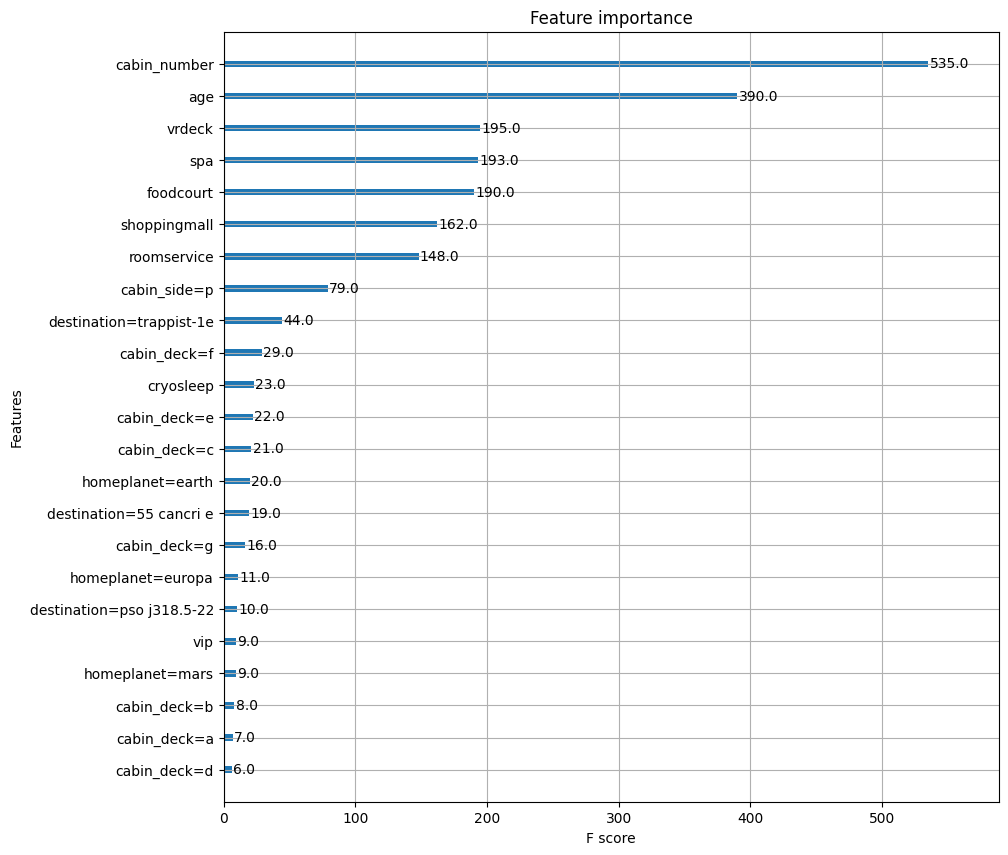

In [10]:
# XGB Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
plt.savefig('feature_importance.png')

## Predict on json

In [14]:
json_data = {
  "PassengerId": 1,
  "HomePlanet": "Earth",
  "CryoSleep": False,
  "Cabin": "A/1/Left",
  "Destination": "Earth",
  "Age": 25,
  "VIP": False,
  "RoomService": 0,
  "FoodCourt": 0,
  "ShoppingMall": 0,
  "Spa": 0,
  "VRDeck": 0,
  "Names": "John Doe"
}

import pandas as pd
from ml.data import basic_preprocess
import xgboost as xgb
# import model
import pickle
model, dv = pickle.load(open('./models/rf_model.pkl', 'rb'))


# convert json to df
df = pd.DataFrame(json_data, index=[0])

# Clean data
df, cat_cols_to_use, num_cols, target = basic_preprocess(df, train=False, target='Transported')

# Final features
final_cols = cat_cols_to_use + list(num_cols)

# convert to dicts
dicts = df[final_cols].to_dict(orient='records')

# transform dicts
X_test = dv.transform(dicts)
#dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)

# predict on test data
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob > 0.5

print(y_pred)


2022-11-02 08:02:08 INFO Replacing " " and "-" with "_" in and  column names and converting to lower case
2022-11-02 08:02:08 INFO Converting CryoSleep to binary
2022-11-02 08:02:08 INFO Converting VIP to binary
2022-11-02 08:02:08 INFO Splitting "cabin" from `deck/num/side` to `deck` `number` and `side`
2022-11-02 08:02:08 INFO Found 5 categorical columns
2022-11-02 08:02:08 INFO Categorical columns: ['homeplanet', 'destination', 'names', 'cabin_deck', 'cabin_side']
2022-11-02 08:02:08 INFO Found 10 numerical columns
2022-11-02 08:02:08 INFO Numerical columns: ['passengerid', 'cryosleep', 'age', 'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'cabin_number']
2022-11-02 08:02:08 INFO Converting str to lower case
2022-11-02 08:02:08 INFO Removing target from cat_cols or num_cols
2022-11-02 08:02:08 INFO Filling categorical columns with mode
2022-11-02 08:02:08 INFO Filling numerical columns with mean


TypeError: float() argument must be a string or a real number, not 'DMatrix'

In [13]:
from ml.model import load_model
# load model and dv
model, dv = load_model('./models/xgb_model.pkl')

# convert json to df
df = pd.DataFrame(json_data, index=[0])

# Clean data
df, cat_cols_to_use, num_cols, target = basic_preprocess(df, train=False, target='Transported')

df.info()

# Final features
final_cols = cat_cols_to_use + list(num_cols)

# convert to dicts
dicts = df[final_cols].to_dict(orient='records')

if xgb:
    # transform dicts
    X_test = dv.transform(dicts)
    dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)

    # predict on test data
    y_pred_prob = model.predict(dtest)
    y_pred = y_pred_prob > 0.5
else:
    # transform dicts
    X = dv.transform(dicts)

    # Predict
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = y_pred_prob > 0.5

print(y_pred)

2022-11-02 07:44:57 INFO Loading model from ./models/xgb_model.pkl
2022-11-02 07:44:57 INFO Replacing " " and "-" with "_" in and  column names and converting to lower case
2022-11-02 07:44:57 INFO Converting CryoSleep to binary
2022-11-02 07:44:57 INFO Converting VIP to binary
2022-11-02 07:44:57 INFO Splitting "cabin" from `deck/num/side` to `deck` `number` and `side`
2022-11-02 07:44:57 INFO Found 5 categorical columns
2022-11-02 07:44:57 INFO Categorical columns: ['homeplanet', 'destination', 'names', 'cabin_deck', 'cabin_side']
2022-11-02 07:44:57 INFO Found 10 numerical columns
2022-11-02 07:44:57 INFO Numerical columns: ['passengerid', 'cryosleep', 'age', 'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'cabin_number']
2022-11-02 07:44:57 INFO Converting str to lower case
2022-11-02 07:44:57 INFO Removing target from cat_cols or num_cols
2022-11-02 07:44:57 INFO Filling categorical columns with mode
2022-11-02 07:44:57 INFO Filling numerical columns with mean


[07:44:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   passengerid   1 non-null      int64   
 1   homeplanet    1 non-null      object  
 2   cryosleep     1 non-null      category
 3   destination   1 non-null      object  
 4   age           1 non-null      int64   
 5   vip           1 non-null      category
 6   roomservice   1 non-n

[{'homeplanet': 'earth', 'destination': 'earth', 'cabin_deck': 'a', 'cabin_side': 'left', 'passengerid': 1, 'cryosleep': 0, 'age': 25, 'vip': 0, 'roomservice': 0, 'foodcourt': 0, 'shoppingmall': 0, 'spa': 0, 'vrdeck': 0, 'cabin_number': 1.0}]
[ True]
